In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
sys.path.append("/content/drive/MyDrive/#fastcampus")
drive_project_root = "/content/drive/MyDrive/#fastcampus"
!pip install -r "/content/drive/MyDrive/#fastcampus/requirements.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datetime import datetime

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from omegaconf import DictConfig
import hydra
from hydra.core.config_store import ConfigStore

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa

import wandb

In [3]:
from config_utils_tf import flatten_dict
from config_utils_tf import register_config
from config_utils_tf import get_optimizer_element
from config_utils_tf import get_callbacks

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!nvidia-smi

Mon Dec 27 06:50:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    30W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 데이터 및 데이터로더 정의

## 모델 정의

In [6]:
class VAE(tf.keras.Model):
    """Convolutional variational autoencoder"""
    def __init__(self, cfg: DictConfig):
        super().__init__()
        self.cfg = cfg
        self.latent_dim = cfg.model.latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(**cfg.model.enc.conv1),
                tf.keras.layers.Conv2D(**cfg.model.enc.conv2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(cfg.model.enc.out_fc.units),
            ],
            name="encoder"
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    units=cfg.model.dec.in_fc.units,
                    activation=tf.nn.relu
                ),
                tf.keras.layers.Reshape(
                    target_shape=tuple(cfg.model.dec.reshape_shape)
                ),
                tf.keras.layers.Conv2DTranspose(**cfg.model.dec.tr_conv1),
                tf.keras.layers.Conv2DTranspose(**cfg.model.dec.tr_conv2),
                tf.keras.layers.Conv2DTranspose(**cfg.model.dec.tr_conv3),
            ],
            name="decoder"
        )

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker
        ]

    @tf.function
    def sample(self, epsilon=None, sample_size=100):
        if epsilon is None:
            epsilon = tf.random.normal(shape=(sample_size, self.latent_dim))
        return self.decode(epsilon)
        
    def encode(self, x, training=False):
        mu, logvar = tf.split(self.encoder(x, training=training),
            num_or_size_splits=2,
            axis=1
        )
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """get z"""
        epsilon = tf.random.normal(shape=mu.shape)
        return mu + epsilon * tf.exp(logvar * 0.5)

    def decode(self, z, training=False):
        return tf.sigmoid(self.decoder(z, training=training))

    def call(self, input, training=False):
        mu, logvar = self.encode(input, training=training)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, training=training)
        return output, z, mu, logvar

    def train_step(self, data):
        images, _ = data
        # images = [B X 28 X 28] -> [B X 28 X 28 X 1]
        images = tf.cast(tf.expand_dims(images, -1), tf.float32)

        with tf.GradientTape() as tape:
            outputs, z, z_mu, z_logvar = self(images, training=True)
            
            # reconstuction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mae(images, outputs),
                    axis=(1, 2)
                )
            )

            # kld_loss
            kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mu) - tf.exp(z_logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # total_loss
            total_loss = recon_loss + kl_loss

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # update the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # tensorboard image update
        tf.summary.image("train_source_img", images, max_outputs=5)
        tf.summary.image("train_recon_img", outputs, max_outputs=5)
        
        # return a dic mapping metrics names to current values
        logs = {m.name: m.result() for m in self.metrics}
        return logs

    def test_step(self, data):
        images, _ = data
        # images = [B X 28 X 28] -> [B X 28 X 28 X 1]
        images = tf.cast(tf.expand_dims(images, -1), tf.float32)

        outputs, z, z_mu, z_logvar = self(images, training=True)
            
        # reconstuction loss
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.mae(images, outputs),
                axis=(1, 2)
            )
        )

        # kld_loss
        kl_loss = -0.5 * (1 + z_logvar - tf.square(z_mu) - tf.exp(z_logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        # total_loss
        total_loss = recon_loss + kl_loss

        # update the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # tensorboard image update
        tf.summary.image("val_source_img", images, max_outputs=5)
        tf.summary.image("val_recon_img", outputs, max_outputs=5)
        
        # return a dic mapping metrics names to current values
        logs = {m.name: m.result() for m in self.metrics}
        return logs

## Configuration 정의

In [7]:
# model configuration
data_fashion_mnist_cfg: dict = {
    "n_class": 10,
    "train_val_split": [0.9, 0.1],
    "train_val_shuffle": True,
    "train_val_shuffle_buffer_size": 1024,
    "test_shuffle": False,
    "test_shuffle_buffer_size": 1024
}

model_mnist_vae_cfg: dict = {
    "name": "VAE",
    "data_normalize": True,
    "latent_dim": 2,
    "enc": {
        "conv1": {
            "filters": 32,
            "kernel_size": 3,
            "strides": [2, 2],
            "activation": "relu"
        },
        "conv2": {
            "filters": 64,
            "kernel_size": 3,
            "strides": [2, 2],
            "activation": "relu"
        },
        "out_fc": {
            "units": 4, # latent_dim *2 (mu, log_var)
        }
    },
    "dec": {
        "in_fc": {
            "units": 7*7*32
        },
        "reshape_shape": [7, 7, 32],
        "tr_conv1" : {
            "filters": 64,
            "kernel_size": 3,
            "strides": [2, 2],
            "padding": "same",
            "activation": "relu"
        },
        "tr_conv2" : {
            "filters": 32,
            "kernel_size": 3,
            "strides": [2, 2],
            "padding": "same",
            "activation": "relu"
        },
        "tr_conv3" : {
            "filters": 1,
            "kernel_size": 3,
            "strides": [1, 1],
            "padding": "same",
        },
    }
}

# optimizer configs
adam_warmup_lr_sch_opt_cfg = {
    "optimizer": {
        "name": "Adam",
        "other_kwargs": {},
    },
    "lr_scheduler": {
        "name": "LinearWarmupLRSchedule",
        "kwargs": {
            "lr_peak": 1e-3,
            "warmup_end_steps": 1500,
        }
    }
}
radam_no_lr_sch_opt_cfg = {
    "optimizer": {
        "name": "RectifiedAdam",
        "learning_rate": 1e-3,
        "other_kwargs": {},
    },
    "lr_scheduler": None,
}

# train_cfg
train_cfg: dict = {
    "train_batch_size": 256,
    "val_batch_size": 32,
    "test_batch_size": 32,
    "max_epochs": 50,
    "distribute_strategy": "MirroredStrategy",
}

_merged_cfg_presets = {
    "vae_fashion_mnist_radam": {
        "data": data_fashion_mnist_cfg,
        "model": model_mnist_vae_cfg,
        "opt": radam_no_lr_sch_opt_cfg,
        "train": train_cfg,
    },
}

### hydra composition ###
# clear hydra instance
hydra.core.global_hydra.GlobalHydra.instance().clear()

# register preset configs
register_config(_merged_cfg_presets)

# initialization
hydra.initialize(config_path=None)

using_config_key = "vae_fashion_mnist_radam"
cfg = hydra.compose(using_config_key)

# override log_cfg
model_name = cfg.model.name
run_dirname = "fastcampus_generative_model_tutorials_tf"
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{using_config_key}-{model_name}"
log_dir = os.path.join(drive_project_root, "runs", run_dirname, run_name)

log_cfg ={
    "run_name": run_name,
    'callbacks': {
        "TensorBoard": {
            "log_dir": log_dir,
            "update_freq": 10,
        },
    },
    "wandb": {
        "project": "fastcampus_generative_model_tutorials_tf",
        "name": run_name,
        "tags": ["fastcampus_generative_model_tutorials_tf"],
        "reinit": True,
        "sync_tensorboard": True
    }
}
# unlock struct of config & set log config
OmegaConf.set_struct(cfg, False)
cfg.log = log_cfg

# relock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))

# save yaml
# with open(os.path.join(log_dir, "config.yaml")) as f:
# with open("config.yaml", "w") as f:
#     OmegaConf.save(cfg, f)


data:
  n_class: 10
  train_val_split:
  - 0.9
  - 0.1
  train_val_shuffle: true
  train_val_shuffle_buffer_size: 1024
  test_shuffle: false
  test_shuffle_buffer_size: 1024
model:
  name: VAE
  data_normalize: true
  latent_dim: 2
  enc:
    conv1:
      filters: 32
      kernel_size: 3
      strides:
      - 2
      - 2
      activation: relu
    conv2:
      filters: 64
      kernel_size: 3
      strides:
      - 2
      - 2
      activation: relu
    out_fc:
      units: 4
  dec:
    in_fc:
      units: 1568
    reshape_shape:
    - 7
    - 7
    - 32
    tr_conv1:
      filters: 64
      kernel_size: 3
      strides:
      - 2
      - 2
      padding: same
      activation: relu
    tr_conv2:
      filters: 32
      kernel_size: 3
      strides:
      - 2
      - 2
      padding: same
      activation: relu
    tr_conv3:
      filters: 1
      kernel_size: 3
      strides:
      - 1
      - 1
      padding: same
opt:
  optimizer:
    name: RectifiedAdam
    learning_rate: 0.001
  

In [8]:
def get_distribute_strategy(strategy_name: str, **kwargs):
    return getattr(tf.distribute, strategy_name)(**kwargs)

distribute_strategy = get_distribute_strategy(cfg.train.distribute_strategy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [9]:
with distribute_strategy.scope():
    # 데이터 새 정의
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # normalization
    if cfg.model.data_normalize:
        x_train = x_train / 255.0
        x_test = x_test / 255.0

    # train/val splits
    assert sum(cfg.data.train_val_split) == 1.0
    train_size = int(len(x_train) * cfg.data.train_val_split[0])
    val_size = len(x_train) - train_size

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    if cfg.data.train_val_shuffle:
        dataset = dataset.shuffle(
            buffer_size=cfg.data.train_val_shuffle_buffer_size
        )
    if cfg.data.test_shuffle:
        test_dataset = test_dataset.shuffle(
            buffer_size=cfg.data.test_shuffle_buffer_size
        )

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    print(len(train_dataset), len(val_dataset), len(dataset), len(test_dataset))

    # dataloader 정의
    train_batch_size = cfg.train.train_batch_size
    val_batch_size = cfg.train.val_batch_size
    test_batch_size = cfg.train.test_batch_size

    train_dataloader = train_dataset.batch(train_batch_size, drop_remainder=True)
    val_dataloader = val_dataset.batch(val_batch_size, drop_remainder=True)
    test_dataloader = test_dataset.batch(test_batch_size, drop_remainder=True)

sample_example = next(iter(train_dataloader))
print(sample_example)

54000 6000 60000 10000
(<tf.Tensor: shape=(256, 28, 28), dtype=float64, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0

In [10]:
# 모델 정의
def get_model(cfg: DictConfig):
    if cfg.model.name == "VAE":
        model = VAE(cfg)
    else:
        raise NotImplementedError()

    return model

with distribute_strategy.scope():
    model = get_model(cfg)

    # define optimizer
    optimizer, scheduler = get_optimizer_element(
        cfg.opt.optimizer, cfg.opt.lr_scheduler
    )


    model.compile(optimizer=optimizer)

    model.build((train_batch_size, 28, 28, 1))
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
# get callbacks
callbacks = get_callbacks(cfg.log)

# wandb setup
wandb.init(
    config=flatten_dict(cfg),
    **cfg.log.wandb
)

wandb: Currently logged in as: lemma17 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [12]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/\#fastcampus/runs/fastcampus_generative_model_tutorials_tf

model.fit(
    train_dataloader,
    validation_data=val_dataloader,
    epochs=cfg.train.max_epochs,
    callbacks=callbacks
)

Reusing TensorBoard on port 6006 (pid 1642), started 0:06:43 ago. (Use '!kill 1642' to kill it.)

<IPython.core.display.Javascript object>

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead
209/210 [============================>.] - ETA: 0s - total_loss: 224.4743 - recon_loss: 221.7755 - kl_loss: 2.6988

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


210/210 [==============================] - 18s 60ms/step - total_loss: 224.1596 - recon_loss: 221.4552 - kl_loss: 2.7044 - val_total_loss: 154.2844 - val_recon_loss: 150.2204 - val_kl_loss: 4.0639
Epoch 2/50
210/210 [==============================] - 15s 73ms/step - total_loss: 132.6866 - recon_loss: 128.4310 - kl_loss: 4.2556 - val_total_loss: 107.4893 - val_recon_loss: 102.6853 - val_kl_loss: 4.8040
Epoch 3/50
210/210 [==============================] - 17s 82ms/step - total_loss: 98.7956 - recon_loss: 93.8705 - kl_loss: 4.9251 - val_total_loss: 94.0696 - val_recon_loss: 88.9874 - val_kl_loss: 5.0823
Epoch 4/50
210/210 [==============================] - 13s 63ms/step - total_loss: 91.5915 - recon_loss: 86.3897 - kl_loss: 5.2018 - val_total_loss: 90.6269 - val_recon_loss: 85.3323 - val_kl_loss: 5.2946
Epoch 5/50
210/210 [==============================] - 13s 60ms/step - total_loss: 88.6279 - recon_loss: 83.3862 - kl_loss: 5.2418 - val_total_loss: 87.9422 - val_recon_loss: 82.6756 - val

## Model testing

In [ ]:
# model.evaluate(test_dataloader)

100/100 [==============================] - 2s 6ms/step - loss: 0.3304 - accuracy: 0.8824


[0.3303638696670532, 0.8823999762535095]

<function matplotlib.pyplot.show>

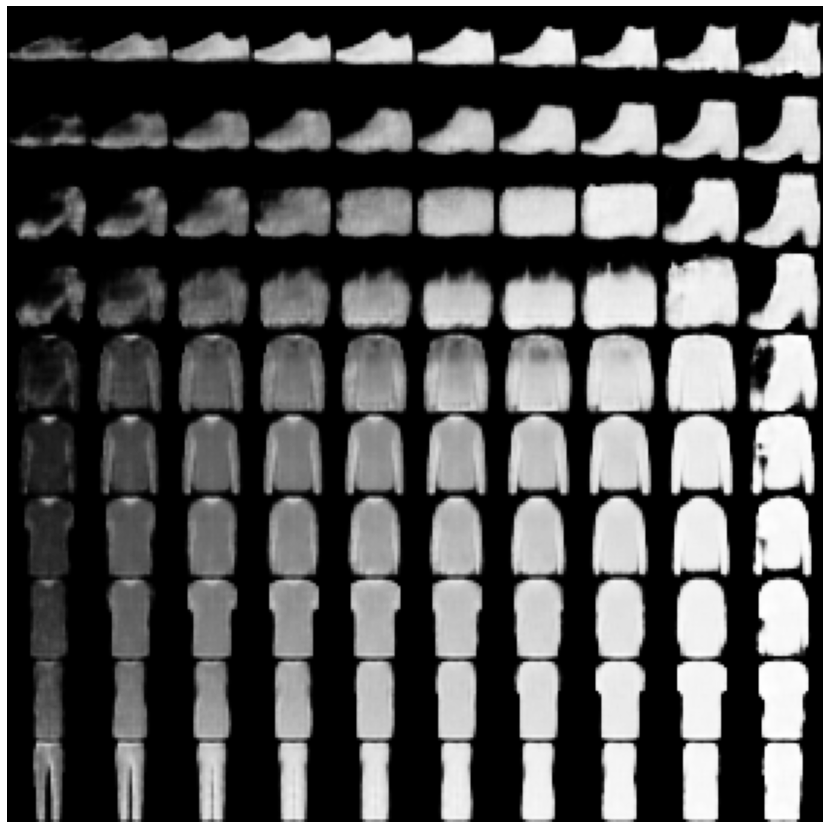

In [20]:
def get_latent_img(model, n , single_img_size=28):
    """plot n x n images decoded from the latent_space"""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    width = single_img_size * n
    height = width
    image = np.zeros((height, width))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            # x_decoded = model.decode(z)
            digit = tf.reshape(x_decoded[0], (single_img_size, single_img_size))
            image[i*single_img_size:(i + 1)*single_img_size,
                  j*single_img_size:(j + 1)*single_img_size] = digit.numpy()
    return image

latent_img = get_latent_img(model, n=10)
plt.figure(figsize=(15, 15))
plt.imshow(latent_img, cmap="Greys_r")
plt.axis("Off")
plt.show